# Analysing Auction Performance
The notebook contains the code required to conduct a Bayesian data analysis on data collected from a set of multi-lot on-line auction events executed in Europen markets, over the past year. We will build interpretable models of the average Return-on-Reserve, using variables that describe various facets of multi-lot on-line auction events (e.g. the average number of bidders per-lot).

The ultimate aim of this endeavour is for this notebook (and it's surrounding directory structure) to serve as a template workflow for conducting an end-to-end Bayesian data analysis using PyMC3. It includes many helper functions for automating otherwise tedious tasks (e.g. interacting with Theano to score models on test data) and examples of how data pre-processing can be integrated with Scikit-Learn. The overall approach has been heavily inspired by the book 'Statistical Rethinking - A Bayesian Course with Examples in R and Stan', by Richard McElreath http://xcelab.net/rm/statistical-rethinking/, which is the most significant book on statistics and modelling that I have read during a career spanning more than a decade.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt

## Load Data and Yield Pandas DataFrame
Load the auction data from CSV file and take a glimpse. In practice, the data need not be in CSV format and could be collected via Spark and then transformed to a Pandas DataFrame directly from a Spark DataFrame, etc.

In [2]:
auction_eval = pd.read_csv('../data/auction_data.csv')

auction_eval.info()
auction_eval.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6220 entries, 0 to 6219
Data columns (total 11 columns):
auction_id         6220 non-null int64
avg_start_bid      6220 non-null float64
product_types      6220 non-null float64
auction_mech       6220 non-null object
lots               6220 non-null int64
BPL                6220 non-null float64
RoR                6220 non-null float64
auction_revenue    6220 non-null float64
auction_value      6220 non-null float64
country            6220 non-null object
avg_reserve        6220 non-null float64
dtypes: float64(7), int64(2), object(2)
memory usage: 534.6+ KB


,auction_id,avg_start_bid,product_types,auction_mech,lots,BPL,RoR,auction_revenue,auction_value,country,avg_reserve
0,23716,0.000000,0.822222,EnglishForward,45,11.066667,0.984284,35260.193359,994062.735352,TR,22090.283008
1,23717,0.000000,0.634615,EnglishForward,52,11.000000,0.000000,0.000000,975453.023438,TR,18758.711989
2,23721,0.161214,1.000000,EnglishForward,4,7.000000,0.774436,27755.481689,38372.630859,CZ,9593.157715
3,23724,0.000000,0.857143,EnglishForward,28,17.464286,0.933634,373000.000000,453479.647461,International,16195.701695
4,23725,0.000000,0.820513,EnglishForward,39,11.487179,0.957757,328000.000000,340600.000000,International,8733.333333


### Data Description
- **auction_id** - unique identifier for a single multi-lot online auction event;
- **auction revenue** - revenue realised from all lots sold in a multi-lot online auction event;
- **auction value** - the estimated value of all lots in a multi-lot online auction event (sum of reserve prices);
- **RoR** - the average Return-on-Reserve for successfully sold lots in the multi-lot online auction event, computed as realised price divided by reserve price;
- **lots** - the number of lots offered in the multi-lot online auction event;
- **product_types** - the number of different product types offered in the multi-lot online auction event;
- **avg_reserve** - the average reserve price over all lots in the multi-lot online auction event
- **avg_start_bid** - the average starting-bid over all lots in the multi-lot online auction event
- **BPL** - the average number of bidders per-lot;
- **auction_mech** - the auction mechanim used for the auction event (one of English Forward, Sealed Bid or Fixed Price); and,
- **country** - the local market running the auction.

### Initial Variable Selection
We choose the following variables to use for trying to understand and predict RoR:
- **lots** - with the aim for controlling for the presence of available alternatives;
- **avg_reserve** - to control for lot value - e.g. lower value lots may see more bidders willing to go above the reserve and vice-versa;
- **avg_start_bid** - to control for the presence of a public price signal (we may need to derive this);
- **BPL** - we know from basic auction theory, that the more bidders there are, then the better the expected prices will be;
- **auction_mech** - whether the lots were traded via English Forward (EF) or Sealed Bid (SB) auctions; and,
- **country** - to control for differences between local markets.

In [3]:
RoR = ['RoR']
model_vars = ['lots', 'avg_reserve', 'avg_start_bid', 'BPL', 'auction_mech', 'country']

## Data Exploration
Through visualisation and descriptive statistics we try to understand the characteristics of the individual variables that are available for using to predict RoR.

### Descriptive Statistics

In [4]:
auction_eval[RoR + model_vars].head()

,RoR,lots,avg_reserve,avg_start_bid,BPL,auction_mech,country
0,0.984284,45,22090.283008,0.000000,11.066667,EnglishForward,TR
1,0.000000,52,18758.711989,0.000000,11.000000,EnglishForward,TR
2,0.774436,4,9593.157715,0.161214,7.000000,EnglishForward,CZ
3,0.933634,28,16195.701695,0.000000,17.464286,EnglishForward,International
4,0.957757,39,8733.333333,0.000000,11.487179,EnglishForward,International


### Outlier Removal and other Dataset Filtering
Some outliers have obviously still found their way into the data. So, we will limit our modelling dataset by filtering-out values that don't feel correct based on our knowledge of the data (and the issues embedded within it). As such, we will filter-out the top percentile of RoR values as we know there is ambiguity surrounding reserve prices. Likewise, we have spotted auction events with average reserve prices in the millions of Euros, so we will filter-out the top percentile of mean reserve price observations, as well.

We will also exclude Fixed Price (FP) auction events from the dataset as the RoR for these auction events is fixed at 1 and all auction events where nothing was sold and nothing can be said about price and RoR (i.e. auctin_revenue = 0).

In [5]:
pctile_thold = 0.99

model_data = (
    auction_eval.copy()
    .loc[(auction_eval['auction_revenue'] > 0)
         & (auction_eval['auction_mech'] != 'FixedPrice')
         & (auction_eval['RoR'] < auction_eval['RoR'].quantile(pctile_thold))
         & (auction_eval['avg_reserve'] < auction_eval['avg_reserve'].quantile(pctile_thold)),
         :]
    .assign(country = auction_eval['country'].apply(lambda x: 'country_' + x),
            auction_mech = auction_eval['auction_mech'].apply(lambda x: 'auction_mech_' + x))
    [RoR + model_vars])

desc_vars = [
    'auction_id']

model_data.describe()

,RoR,lots,avg_reserve,avg_start_bid,BPL
count,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,0.989743,48.491018,11099.072681,0.205143,8.251535
std,0.140135,39.081027,4910.386793,0.390067,4.722761
min,0.052569,1.000000,400.000000,0.000000,1.000000
25%,0.921498,17.000000,7378.053377,0.000000,3.833333
50%,1.000367,40.000000,10218.566667,0.000000,8.700000
75%,1.041915,74.000000,13731.054182,0.000000,11.673864
max,1.617087,516.000000,30198.234375,1.000000,36.000000


### RoR
Starting by reminding ourselves of the distributional characteristics of RoR.

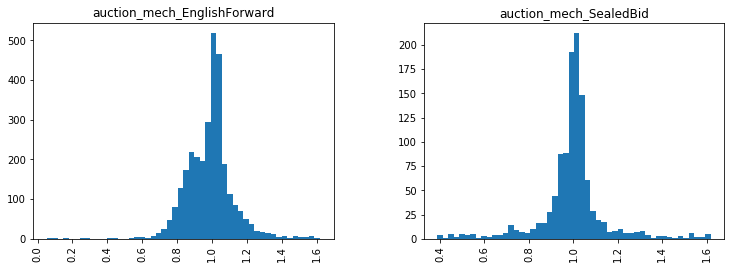

In [6]:
_ = (model_data[RoR + ['auction_mech']]
    .hist(by='auction_mech', bins=50, figsize=(12, 4)))

- EF auctions appear to have a bi-model distribution; and,
- SB auctions appear to have 'fat tails' - i.e. could be well approximated with a Student-T distribution.

We now take a deeper look into EF auctions and the distribution of RoR by wether or not start bids were used.

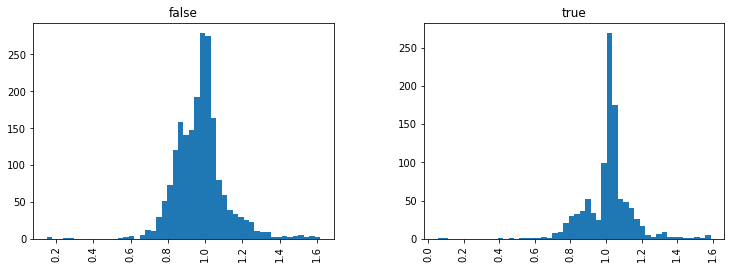

In [7]:
_ = (model_data
    .query('auction_mech == "auction_mech_EnglishForward"')
    .assign(has_start_bids = auction_eval['avg_start_bid']
            .apply(lambda x: 'true' if x > 0 else 'false'))
    [RoR + ['has_start_bids']]
    .hist(by='has_start_bids', bins=50, figsize=(12, 4)))

So the bi-modality in RoR does appear to originate from the presence of start bids (above left). This sub-distribution is, however, also bi-model so all of our queston have not been answered. We continue to dig-in to this and look at a scatter plot of RoR vs. avg_start_bid to see if the magnitude of the start bids plays a part in what we are observing.

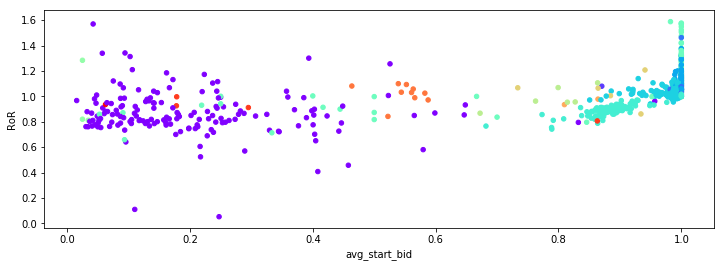

In [8]:
start_bid_analysis = (
    model_data
    .query('auction_mech == "auction_mech_EnglishForward"')
    .query('avg_start_bid > 0'))

_ = (start_bid_analysis
    .plot('avg_start_bid', 'RoR', kind='scatter', 
          c=start_bid_analysis['country'].factorize()[0], cmap='rainbow', 
          colorbar=False, figsize=(12, 4)))

Based on the above plot, it appears that there are some countries that are setting start bids that are greater-than-or-equal to the reserve price. Thinking back to my data engineering endeavours that led to this dataset, the original 'reserve price waterfall' that I implemented (in SQL to generate the event data) to infer reserve prices when they have not been explicitly set in the place where they are expected, will revert to the start-bid if this is the only source of informaton available on price. Will will filter-out these data point before we start modelling in earnest.

There are 261 observations with spurious start bid (and hence reserve price) data to filer-out.


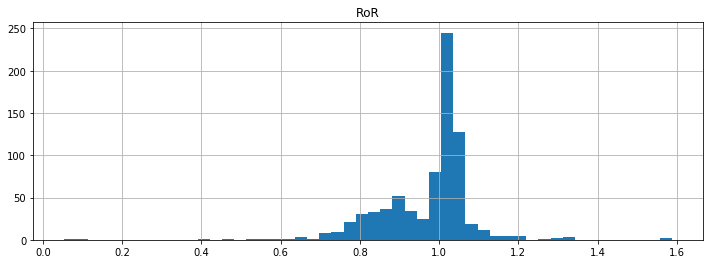

In [9]:
print('There are {} observations with spurious start bid (and hence reserve price) data to filer-out.'
      .format(model_data.query('avg_start_bid >= 1').shape[0]))

_ = (start_bid_analysis
    .query('avg_start_bid < 1')
    [RoR]
    .hist(bins=50, figsize=(12, 4)))

We can, however, see from the filtered distribution above that the bi-modality is still present. With recourse to the scatter plot above, we can see that the bi-modality is country-related, which justifies the choice of country as a potential explanetory variable that we may need to control for.

### Independent Variables
We now turn our attention to the distributional characteristics of each potential numerical modelling variable.

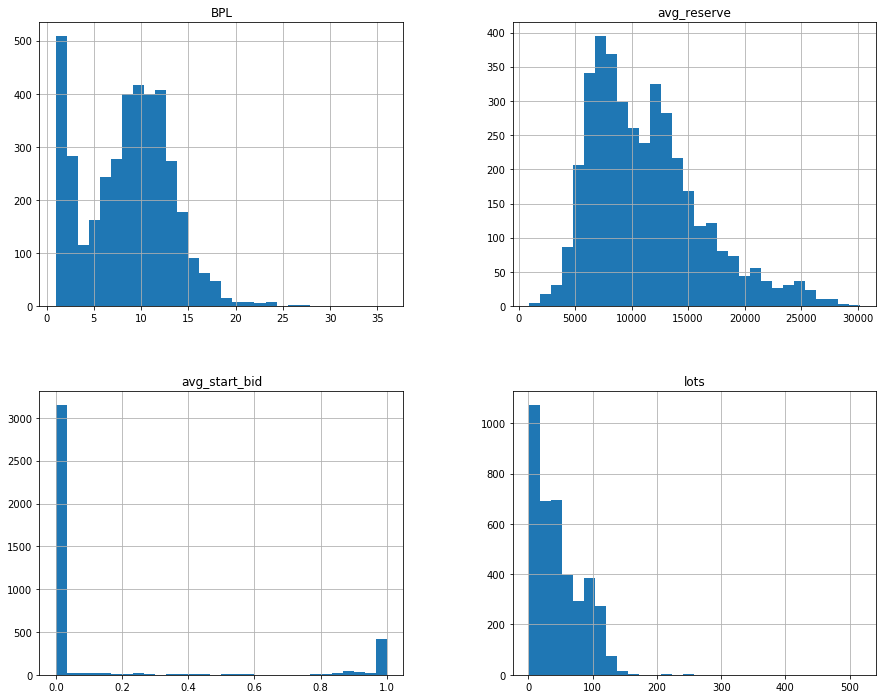

In [10]:
_ = (model_data[model_vars]
     .query('avg_start_bid < 1')
     .hist(bins=30, figsize=(15, 12)))

### Dependency Structure and Correlations
Taking a superficial look at variate-by-variate scatter plots and Pearson correlations between RoR and the initial modelling variables, for a single country ('International' - the pan-European online market), and trading mechanism (English Forward). We have deliberatly looked at a specific (conditioned) slice through the data as it will be representitive fo the kinds of models we will build using the categorical data and because visually, different relationships relating to the different market structures and dynamics associated with different entities and mechanisms, will not obfuscate any pattern.

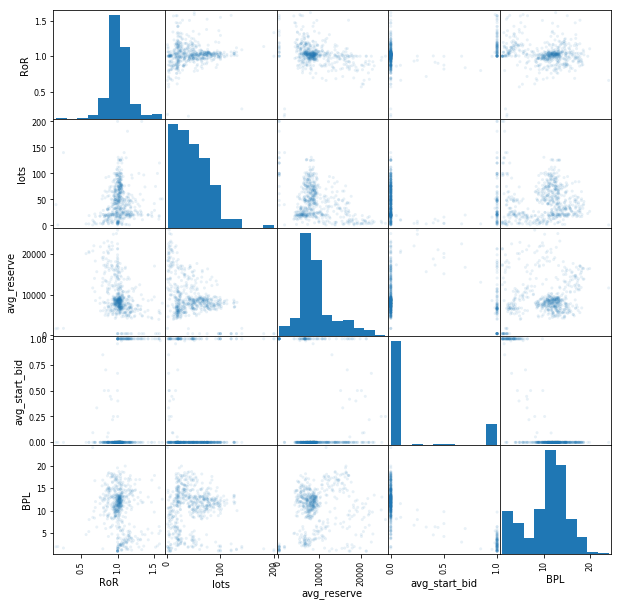

In [11]:
_ = pd.plotting.scatter_matrix(
    (model_data[RoR + model_vars]
     .query('country == "country_International"')
     .query('auction_mech == "auction_mech_EnglishForward"')),
    figsize=(10, 10), alpha=0.1)

In [12]:
model_data[RoR + model_vars].corr()

,RoR,lots,avg_reserve,avg_start_bid,BPL
RoR,1.000000,0.069050,-0.072248,0.175049,-0.070454
lots,0.069050,1.000000,-0.013865,0.365629,-0.150326
avg_reserve,-0.072248,-0.013865,1.000000,-0.000236,-0.142450
avg_start_bid,0.175049,0.365629,-0.000236,1.000000,-0.617774
BPL,-0.070454,-0.150326,-0.142450,-0.617774,1.000000


Intital thoughts on the choice of modelling variables:
- **avg_start_bid** should be mapped to a categorical variable 'has_start_bid';
- neglecting **avg_start_bid**, there doesn't appear to be any obvious sources of multi-collinearity that could interfere with model interpretability.

## Modelling RoR using Bayesian Inference
Whereas in the past we have trained multiple ML algorithms when the ultimate aim was prediction, we are currently focused more on statistical learning, model interpretability and modelling real-world economic phenomena - than we are on prediction accuracy. Hence, we will concentrate our efforts on using a single approach - esimating linear regression models using Bayesian inference techniques.

### Data Preparation Pipeline
We define a data transformation pipeline to:
- select the variables of interest;
- center and scale the continuous variables; and,
- handle categorical features in a way that makes sense for our models - e.g. encoding factors (or levels) as opposed to one-hot encoding.

The motivation for centering and scaling the data is threefold:
1. the numerical routines required for computing MAP estimtes and posterior distribution samples are more stable when all of the input variates have the same scale (i.e. the same units);
2. centering the variates so that the mean level corresponds to 0 makes it easy to isolate the impact that just one independent variable (e.g. lots), has on the dependent variable (i.e. RoR), by setting all other variables to 0 (i.e. their mean level); and,
3. both centering and scaling the variables by the standard deviation leads to easy interpration and comparison of parameters estimates - e.g if an estimate parameter is 1, then we know that when the independent variable (e.g. lots), is 1 standard deviation above the mean, then it will impact the dependent variable (i.e. RoR), by precisely 1. Being able to make these sorts of relative judgement is useful when choosing prior distributions for model parameters.

In [13]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer


def cat_col_selector(df):
    df_cat = df.select_dtypes(include=['object'])
    return df_cat.values


def num_col_selector(df):
    df_num = df.select_dtypes(exclude=['object'])
    return df_num.values


def cat_col_str2fact(X):
    fact_cols = [LabelEncoder().fit_transform(col) for col in X.T]
    fact_mat = np.vstack(fact_cols)
    return fact_mat.T


def cat_col_fact_names(df):
    def list_of_fact_names(col):
        fact_names = LabelEncoder().fit(col).classes_
        return fact_names.tolist()
    df_cat = df.select_dtypes(include=['object'])
    X = df_cat.values
    fact_name_cols = [(col_name, list_of_fact_names(col)) 
                      for col_name, col in zip(df_cat.columns, X.T)]    
    return dict(fact_name_cols)


def make_new_vars(df):
    start_bid_map = lambda x: 'start_bids_true' if x > 0 else 'start_bids_false'
    new_df = df.assign(start_bids=df['avg_start_bid'].apply(start_bid_map))
    return new_df


bayes_data_pipe = Pipeline([
    ('make_new_vars', FunctionTransformer(make_new_vars, validate=False)),
    ('union', FeatureUnion([
        ('num_vars', Pipeline([
            ('get_num_vars', FunctionTransformer(num_col_selector, validate=False)),
            ('scale_vars', StandardScaler())
        ])),        
        ('cat_vars', Pipeline([
            ('get_cat_vars', FunctionTransformer(cat_col_selector, validate=False)),
            ('factorise', FunctionTransformer(cat_col_str2fact, validate=False))
        ]))
    ]))
])

num_var_names = (
    make_new_vars(model_data[model_vars])
    .select_dtypes(exclude=['object'])
    .columns
    .tolist())

cat_var_names = (
    make_new_vars(model_data[model_vars])
    .select_dtypes(include=['object'])
    .columns
    .tolist())

all_var_names = num_var_names + cat_var_names

cat_col_levels = cat_col_fact_names(make_new_vars(model_data[model_vars]))

y = (model_data['RoR']
     .values
     .reshape(-1, ))

X = (bayes_data_pipe
     .fit_transform(model_data[model_vars]))

X_df = pd.DataFrame(X, columns=all_var_names)
X_df.head()

,lots,avg_reserve,avg_start_bid,BPL,auction_mech,country,start_bids
0,-0.089338,2.238627,-0.525979,0.596149,0.0,24.0,0.0
1,-1.138566,-0.306716,-0.112631,-0.265032,0.0,5.0,1.0
2,-0.524384,1.038053,-0.525979,1.950946,0.0,16.0,0.0
3,-0.242884,-0.481840,-0.525979,0.685199,0.0,16.0,0.0
4,1.215799,-0.037788,1.706146,-0.847389,0.0,1.0,1.0


### Partition Data into Test and Train Sets
We select 20% of the available observations to hold-back from training our model on, so that their out-of-sample performance can be tested.

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('{} samples in training dataset and {} samples in test dataset'
      .format(X_train.shape[0], X_test.shape[0]))

3340 samples in training dataset and 835 samples in test dataset


### Define Experimental Setup
In addition to assessing competing models using information criteria (e.g. WAIC), we would also like to understand the Root-Mean-Squared-Error (RMSE) of RoR predictions, both in-sample and out-of-sample. The helper function below faciliates this analysis.

In [15]:
def model_performance(y_, trace_, model_, samples_=500, intvl=0.95):
    post_pred_samp = pm.sample_ppc(trace_, model=model_, samples=samples_)
    pred = post_pred_samp['Y_obs'].mean(axis=0)
    error = pred - y_
    abs_error = np.absolute(error)
    intvl_lwr = (1 - intvl) / 2
    intvl_upr = intvl_lwr + intvl    
    pred_range_lwr = np.percentile(post_pred_samp['Y_obs'], 100*intvl_lwr, axis=0)
    pred_range_upr = np.percentile(post_pred_samp['Y_obs'], 100*intvl_upr, axis=0)
    print('RMSE = {}'.format(np.sqrt(np.mean(error ** 2))))
    performance_data = np.concatenate([
        pred.reshape((-1, 1)), y_.reshape((-1, 1)), 
        pred_range_lwr.reshape((-1, 1)), pred_range_upr.reshape((-1, 1)),
        error.reshape((-1, 1)), abs_error.reshape((-1, 1))], 
        axis=1)
    df = pd.DataFrame(
        performance_data, 
        columns=['predicted', 'actual', 'predicted_lwr', 'predicted_upr', 'error', 'abs_error'])
    return df

### Map Data to Model Variables
To make the model specification easier to read and to facilitate prediction with PyMC3, we explicitly map data columns to their own name. We also explicitly define them as variables in Theano, whose values can be changed, for example, when need to load test data after estimating on training data, and provide two helper functions for this purpose.

In [16]:
from theano import shared

def load_test_data():
    lots.set_value(X_test[:, 0])
    mean_rsv.set_value(X_test[:, 1])
    avg_start_bid.set_value(X_test[:, 2])
    BPL.set_value(X_test[:, 3])
    auction_mech.set_value(X_test[:, 4].astype('int32'))
    country.set_value(X_test[:, 5].astype('int32'))
    start_bids.set_value(X_test[:, 6].astype('int32'))
    return None

def load_train_data():
    lots.set_value(X_train[:, 0])
    mean_rsv.set_value(X_train[:, 1])
    avg_start_bid.set_value(X_train[:, 2])
    BPL.set_value(X_train[:, 3])
    auction_mech.set_value(X_train[:, 4].astype('int32'))
    country.set_value(X_train[:, 5].astype('int32'))
    start_bids.set_value(X_train[:, 6].astype('int32'))
    return None

Y = y_train
lots = shared(X_train[:, 0])
mean_rsv = shared(X_train[:, 1])
avg_start_bid = shared(X_train[:, 2])
BPL = shared(X_train[:, 3])
auction_mech = shared(X_train[:, 4].astype('int32'))
country = shared(X_train[:, 5].astype('int32'))
start_bids = shared(X_train[:, 6].astype('int32'))

### Handling MCMC Simulation Backends and Persistence
If we expend compute-time on running MCMC simulations to evaluate our models, we do not want this to be wasted if we want to re-run a notebook with the models as-is (e.g we add new model and we want to compare WAIC against previous models). To faciliate this effiency we define a function for persisting the chains to disk and only re-computing them if the number of 'draws' or 'tune' steps has changed (or we have explicitly asked it to).

In [17]:
def run_or_load_mcmc(model_, draws_=1000, tune_=500, parallel_chains=2, 
                     path='../results/', force_rerun=False):
    model_str = [k for k, v in globals().items() if v is model_][0]
    path_to_filname = (path + model_str + '_tune' + str(tune_) + "draw" + str(draws_) 
                       + 'chains' + str(parallel_chains))
    with model_:
        try:
            if force_rerun: raise Exception('forcing MCMC re-run')
            print('loading backend: ' + path_to_filname)
            trace = pm.backends.text.load(path_to_filname)
        except:
            print('creating backend: ' + path_to_filname)
            db = pm.backends.Text(path_to_filname)
            trace = pm.sample(draws=draws_, tune=tune_, trace=db, njobs=4)
    return trace

### Model Specification #1 - Weakly Regularising Priors and Normal Likelihood
We start by defining a simple and pragmatic linear model and then estimate it with both MAP and MCMC methods. We have chosen the standard deviation (StdDev) of the priors such that there is a low probability that a 1 StdDev change in an independent variable impacts the dependent variable (RoR), by 1.

We have chosen Normal priors on the parameter estimates to reflect maximal uncertainty (i.e. Entropy) under the constraint of having a fixed mean and variance, while of the prior on sigma we have deliberately chosen a non-flat but weakly regularising prior for the benefit of efficient MCMC estimation.

In [18]:
load_train_data()
ror_model_basic = pm.Model()

n_entities = len(set(X_df['country'].tolist()))
n_auction_mech = len(set(X_df['auction_mech'].tolist()))

with ror_model_basic:

    # priors for unknown model parameters
    alpha_country = pm.Normal('alpha_country', mu=0, sd=0.5, shape=n_entities)
    alpha_auction_mech = pm.Normal('alpha_auction_mech', mu=0, sd=0.5, shape=n_auction_mech)
    alpha_start_bids = pm.Normal('alpha_start_bids', mu=0, sd=0.5, shape=2)
    
    beta_lots = pm.Normal('beta_lots', mu=0, sd=0.5, shape=1)
    beta_mean_rsv = pm.Normal('beta_mean_res', mu=0, sd=0.5, shape=1)
    beta_BPL = pm.Normal('beta_BPL', mu=0, sd=0.5, shape=1)

    sigma = pm.HalfCauchy('sigma', beta=2)

    # expected value
    mu = (alpha_country[country] + alpha_auction_mech[auction_mech] + alpha_start_bids[start_bids]
          + beta_lots[0] * lots + beta_mean_rsv[0] * mean_rsv + beta_BPL[0] * BPL)    

    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

#### MAP Point Estimate
Use optimisation methods to get a point estimate for quick inspection.

In [19]:
ror_model_basic_map = pm.find_MAP(model=ror_model_basic)
ror_model_basic_map

logp = 2,279.6, ||grad|| = 0.90284: 100%|██████████| 117/117 [00:00<00:00, 1013.04it/s] 


{'alpha_auction_mech': array([ 0.53438027,  0.44069178]),
 'alpha_country': array([-0.03354019,  0.07577168,  0.09189449,  0.16575117,  0.13268304,
        -0.06969828, -0.1032326 , -0.13320973,  0.09374261,  0.13293934,
         0.04611534,  0.04393137,  0.49961821,  0.02817084,  0.13044262,
        -0.00798506,  0.0059243 , -0.08511474,  0.06092981,  0.15611926,
        -0.12805134,  0.03451385, -0.12881369, -0.05952048,  0.02569026]),
 'alpha_start_bids': array([ 0.45713176,  0.51794029]),
 'beta_BPL': array([ 0.01928016]),
 'beta_lots': array([-0.01691142]),
 'beta_mean_res': array([-0.02605683]),
 'sigma': array(0.12186791730731016),
 'sigma_log__': array(-2.1048174657543908)}

#### Markov Chain Monte Carlo Estimation
To get better diagnostics, we use Markov Chain Monte Carl (MCMC) techniques to simulate draw samples from the posterior distribution.

In [20]:
ror_model_basic_trace = run_or_load_mcmc(ror_model_basic)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


loading backend: ../results/ror_model_basic_tune500draw1000chains2
creating backend: ../results/ror_model_basic_tune500draw1000chains2


100%|██████████| 1500/1500 [05:52<00:00,  4.25it/s]


Compute the Gelman-Rubin statistic (r-hat) to check for chain convergence on the marginal parameter distributions (we are looking for r-hat values equal to 1).

In [21]:
pm.diagnostics.gelman_rubin(ror_model_basic_trace)

{'alpha_auction_mech': array([ 1.00022046,  1.00022837]),
 'alpha_country': array([ 1.00115483,  1.00165588,  1.0012252 ,  1.00162347,  1.00080611,
         1.00097639,  1.00126435,  1.00120709,  1.00112782,  1.00137603,
         1.0010157 ,  1.00153631,  1.00116117,  1.00103009,  1.00104409,
         1.00132976,  1.00127423,  1.00206425,  1.00143402,  1.00141643,
         1.00121993,  1.00139794,  1.00128709,  1.00093725,  1.00134052]),
 'alpha_start_bids': array([ 1.00090444,  1.00088777]),
 'beta_BPL': array([ 1.00076428]),
 'beta_lots': array([ 1.00044941]),
 'beta_mean_res': array([ 0.99986431]),
 'sigma': 0.99995051948080982}

Compute the effective chain length for each parameter estimate (i.e. accounting for auto-correlation in the chains).

In [22]:
pm.diagnostics.effective_n(ror_model_basic_trace)

{'alpha_auction_mech': array([ 1436.,  1439.]),
 'alpha_country': array([ 510.,  500.,  482.,  493.,  561.,  478.,  480.,  485.,  490.,
         477.,  503.,  504.,  520.,  494.,  487.,  478.,  476.,  572.,
         485.,  481.,  488.,  480.,  489.,  518.,  482.]),
 'alpha_start_bids': array([ 1381.,  1387.]),
 'beta_BPL': array([ 3247.]),
 'beta_lots': array([ 3123.]),
 'beta_mean_res': array([ 3169.]),
 'sigma': 2854.0}

It appears as if the effective number of samples for the average entity levels is relatively low. This is likely to be acceptible for computing means, but may require longer chains for computing intervals, etc.
Now check the trace plots for each parameter sampled from the posterior distribution, for each chain, to get a feel for how well the marginal distributions of each parameter have been explored.

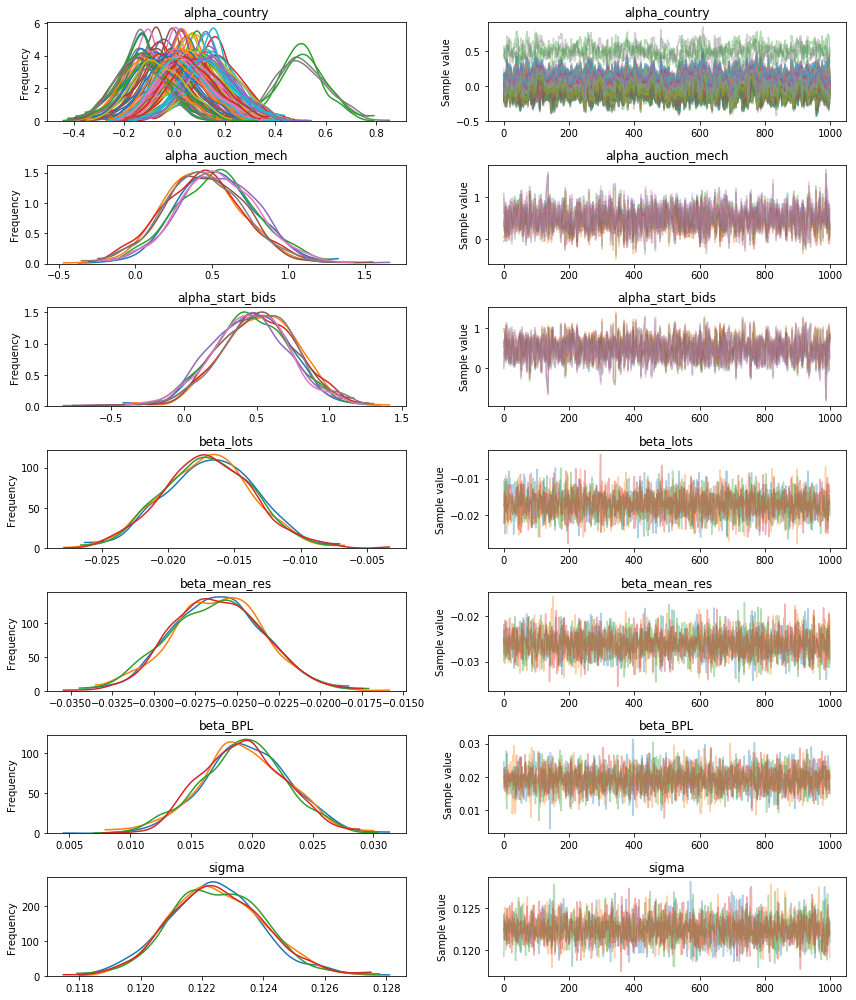

In [23]:
_ = pm.traceplot(ror_model_basic_trace)

Then, we can take a look at the parameter estimates and their credible intervals.

In [24]:
pm.df_summary(ror_model_basic_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha_country__0,-0.031598,0.100343,0.004323,-0.225879,0.172422
alpha_country__1,0.078326,0.098153,0.004175,-0.114789,0.273096
alpha_country__2,0.093923,0.097193,0.004272,-0.097281,0.287472
alpha_country__3,0.168152,0.098467,0.004251,-0.018692,0.367239
alpha_country__4,0.133616,0.105082,0.004275,-0.073605,0.341923
alpha_country__5,-0.067722,0.096493,0.004247,-0.258576,0.128355
alpha_country__6,-0.101210,0.096429,0.004246,-0.289524,0.095842
alpha_country__7,-0.131347,0.096406,0.004222,-0.306854,0.075162
alpha_country__8,0.095756,0.098042,0.004275,-0.101854,0.286835
alpha_country__9,0.135051,0.097035,0.004274,-0.060111,0.327592


#### In-Sample Prediction
Simulate predictions of RoR from the posterior distribution, conditional on observations of the input variables.

100%|██████████| 500/500 [00:01<00:00, 360.95it/s]


RMSE = 0.12206379155968781


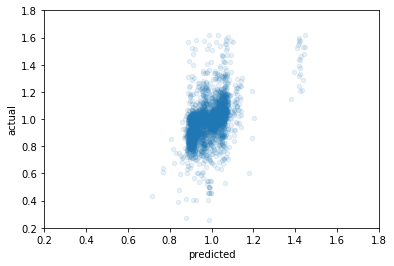

In [25]:
ror_model_basic_insamp = model_performance(y_train, ror_model_basic_trace, ror_model_basic)

_ = (ror_model_basic_insamp
     .plot(kind='scatter', x='predicted', y='actual', xlim=[0.2, 1.8], ylim=[0.2, 1.8], alpha=0.1))

The model shows *some* great performance, but with some terrible estimates as well. We now take a look at the residuals, just because it makes me comfortable to know if there is any structure to the variability in the model.

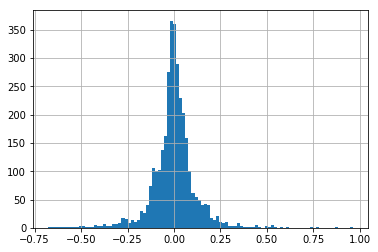

In [26]:
_ = (ror_model_basic_insamp['error']
     .hist(bins=100))

Looks like a nice Student-T distribution would better approximate the 'fat tails' we can see here.

#### Out-of-Sample Prediction

100%|██████████| 500/500 [00:00<00:00, 1866.72it/s]


RMSE = 0.1253962259014002


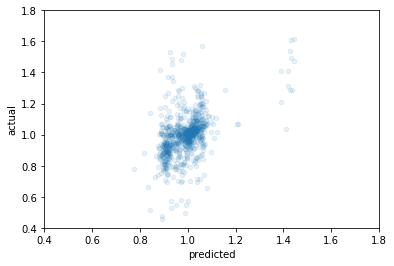

In [27]:
load_test_data()
ror_model_basic_outsamp = model_performance(y_test, ror_model_basic_trace, ror_model_basic)

_ = (ror_model_basic_outsamp
     .plot(kind='scatter', x='predicted', y='actual', xlim=[0.4, 1.8], ylim=[0.4, 1.8], alpha=0.1))

### Model Specification #2 - Weakly Regularising Priors and Robust Estimation
We adapt our basic model to use a Student-T likelihood for robustness to 'fat tails', with the same weakly regularising priors as for model #1.

In [28]:
load_train_data()
ror_model_robust = pm.Model()

with ror_model_robust:

    # priors for unknown model parameters
    alpha_country = pm.Normal('alpha_country', mu=0, sd=0.5, shape=n_entities)
    alpha_auction_mech = pm.Normal('alpha_auction_mech', mu=0, sd=0.5, shape=n_auction_mech)
    alpha_start_bids = pm.Normal('alpha_start_bids', mu=0, sd=0.5, shape=2)
    
    beta_lots = pm.Normal('beta_lots', mu=0, sd=0.5, shape=1)
    beta_mean_rsv = pm.Normal('beta_mean_res', mu=0, sd=0.5, shape=1)
    beta_BPL = pm.Normal('beta_BPL', mu=0, sd=0.5, shape=1)

    nu = pm.HalfCauchy('nu', beta=4)
    sigma = pm.HalfCauchy('sigma', beta=2)

    # expected value
    mu = (alpha_country[country] + alpha_auction_mech[auction_mech] + alpha_start_bids[start_bids]
          + beta_lots[0] * lots + beta_mean_rsv[0] * mean_rsv + beta_BPL[0] * BPL)    

    # likelihood (sampling distribution) of observations
    Y_obs = pm.StudentT('Y_obs', mu=mu, sd=sigma, nu=nu, observed=Y)

#### MAP Point Estimate
Use optimisation methods to get a point estimate for quick inspection.

In [29]:
ror_model_robust_map = pm.find_MAP(model=ror_model_robust)
ror_model_robust_map

logp = 3,138.4, ||grad|| = 2.5284: 100%|██████████| 199/199 [00:00<00:00, 859.30it/s]  


{'alpha_auction_mech': array([ 0.49635902,  0.48203767]),
 'alpha_country': array([ 0.00511861,  0.07798021,  0.02578163,  0.09124492,  0.2580481 ,
        -0.05611562, -0.12113793, -0.08408965,  0.01310846,  0.05654123,
         0.06807741,  0.05277522,  0.50057079, -0.01597531,  0.07841104,
         0.11269654,  0.0325506 , -0.09316995,  0.04347298,  0.0856387 ,
        -0.09883224,  0.049588  , -0.09091486, -0.03103291,  0.0180607 ]),
 'alpha_start_bids': array([ 0.48601735,  0.49237933]),
 'beta_BPL': array([ 0.00146684]),
 'beta_lots': array([-0.00600096]),
 'beta_mean_res': array([-0.00400208]),
 'nu': array(1.433700616323161),
 'nu_log__': array(0.36025894515292567),
 'sigma': array(0.04380198554117019),
 'sigma_log__': array(-3.1280761306370133)}

#### Markov Chain Monte Carlo Model Analysis
To get better diagnostics, we use Markov Chain Monte Carl (MCMC) techniques to simulate draw samples from the posterior distribution.

In [30]:
ror_model_robust_trace = run_or_load_mcmc(ror_model_robust)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


loading backend: ../results/ror_model_robust_tune500draw1000chains2
creating backend: ../results/ror_model_robust_tune500draw1000chains2


100%|██████████| 1500/1500 [13:21<00:00,  1.87it/s]


Compute the Gelman-Rubin statistic (r-hat) to check for chain convergence on the marginal parameter distributions (we are looking for r-hat values equal to 1).

In [31]:
pm.diagnostics.gelman_rubin(ror_model_robust_trace)

{'alpha_auction_mech': array([ 1.00090811,  1.00097583]),
 'alpha_country': array([ 1.00980709,  1.00970535,  1.01059768,  1.01015819,  1.00853677,
         1.00941702,  1.00983151,  1.00951364,  1.01027924,  1.01032599,
         1.0093629 ,  1.00912581,  1.01092627,  1.00997245,  1.01020901,
         1.00904786,  1.00957884,  1.00660218,  1.01019841,  1.01005387,
         1.00979028,  1.00936535,  1.00971292,  1.0097426 ,  1.00962706]),
 'alpha_start_bids': array([ 1.00029829,  1.00030408]),
 'beta_BPL': array([ 0.9996008]),
 'beta_lots': array([ 1.00000856]),
 'beta_mean_res': array([ 0.99993743]),
 'nu': 0.99990392954746532,
 'sigma': 1.0004523979835067}

Compute the effective chain length for each parameter estimate (i.e. accounting for auto-correlation in the chains).

In [32]:
pm.diagnostics.effective_n(ror_model_robust_trace)

{'alpha_auction_mech': array([ 1256.,  1255.]),
 'alpha_country': array([ 196.,  192.,  192.,  194.,  201.,  192.,  191.,  191.,  192.,
         191.,  191.,  195.,  209.,  193.,  198.,  193.,  191.,  212.,
         191.,  193.,  192.,  192.,  193.,  192.,  191.]),
 'alpha_start_bids': array([ 1099.,  1096.]),
 'beta_BPL': array([ 2810.]),
 'beta_lots': array([ 3414.]),
 'beta_mean_res': array([ 2922.]),
 'nu': 2530.0,
 'sigma': 2226.0}

It appears as if the effective number of samples for the average entity levels is relatively low. This is likely to be acceptible for computing means, but may require longer chains for computing intervals, etc.
Now check the trace plots for each parameter sampled from the posterior distribution, for each chain, to get a feel for how well the marginal distributions of each parameter have been explored.

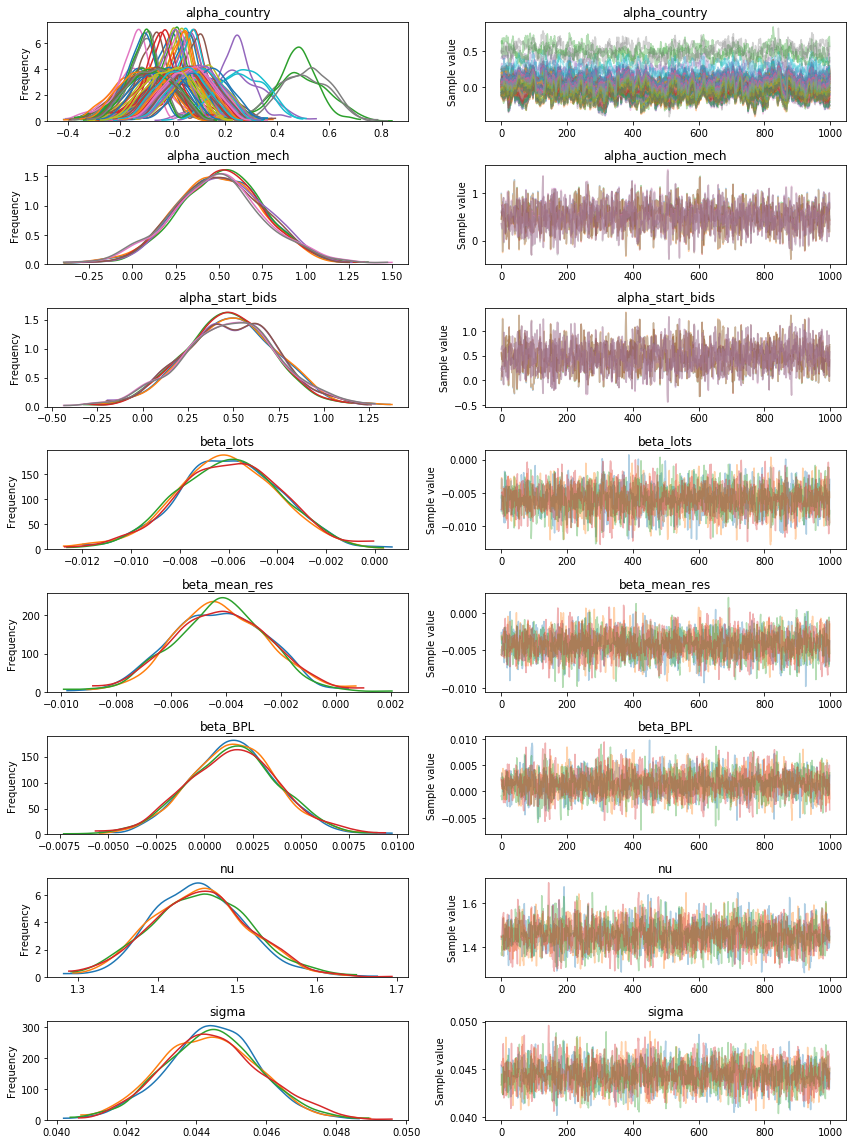

In [33]:
_ = pm.traceplot(ror_model_robust_trace)

Then, we can take a look at the parameter estimates and their credible intervals.

In [34]:
pm.df_summary(ror_model_robust_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha_country__0,-0.002255,0.091267,0.005464,-0.177600,0.179667
alpha_country__1,0.069276,0.091663,0.005522,-0.113793,0.243091
alpha_country__2,0.020147,0.090778,0.005498,-0.159852,0.195663
alpha_country__3,0.084958,0.090913,0.005501,-0.089764,0.264890
alpha_country__4,0.249874,0.092618,0.005506,0.083146,0.443508
alpha_country__5,-0.063341,0.090442,0.005462,-0.237416,0.114675
alpha_country__6,-0.127779,0.090434,0.005490,-0.293629,0.057256
alpha_country__7,-0.091361,0.090435,0.005482,-0.259765,0.091316
alpha_country__8,0.007347,0.090696,0.005492,-0.174144,0.179971
alpha_country__9,0.050829,0.090626,0.005502,-0.114672,0.238827


#### In-Sample Prediction
Simulate predictions of alpha from the posterior distribution, conditional on observations of the input variables (as held within basic_model).

Note, that out-of-sample predictions need to use theano directly to define the independent variables as 'shared' prior to defining the model, and then swapping-in the out-of-sample observations after the model has been estimated. See http://docs.pymc.io/notebooks/posterior_predictive.html for more.

100%|██████████| 500/500 [00:00<00:00, 818.97it/s]


RMSE = 0.1396068241946931


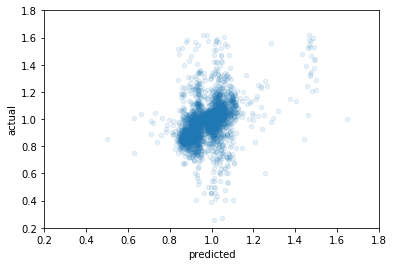

In [35]:
ror_model_robust_insamp = model_performance(y_train, ror_model_robust_trace, ror_model_robust)

_ = (ror_model_robust_insamp
     .plot(kind='scatter', x='predicted', y='actual', xlim=[0.2, 1.8], ylim=[0.2, 1.8], alpha=0.1))

The model shows *some* great performance, but with some terrible estimates as well. We now take a look at the residuals, just because it makes me comfortable to know if there is any structure to the variability in the model.

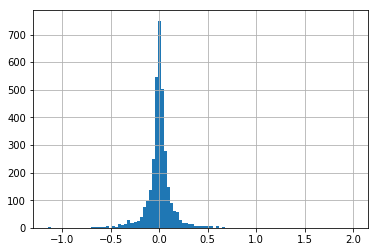

In [36]:
_ = (ror_model_robust_insamp['error']
     .hist(bins=100))

Looks like a nice Student-T distribution, just as we specified in our model! We now use the model to score the test dataset.

#### Out-of-Sample Prediction

100%|██████████| 500/500 [00:00<00:00, 1509.37it/s]


RMSE = 0.1326109399169043


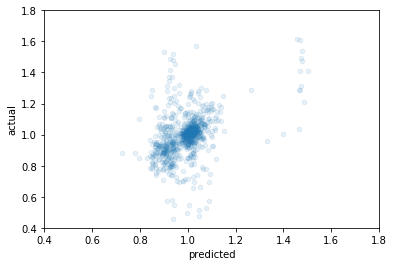

In [37]:
load_test_data()
ror_model_robust_outsamp = model_performance(y_test, ror_model_robust_trace, ror_model_robust)

_ = (ror_model_robust_outsamp
     .plot(kind='scatter', x='predicted', y='actual', xlim=[0.4, 1.8], ylim=[0.4, 1.8], alpha=0.1))

### Model Comparison and Selection
We will select the model with the lowers WAIC for interpretation.

In [38]:
load_train_data()
pm.stats.compare([ror_model_basic_trace, ror_model_robust_trace], 
                 [ror_model_basic, ror_model_robust])

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,-6218.26,51.36,0,0.84,157.38,0,1
0,-4512.06,37.31,1706.2,0.16,179.52,131.81,1


### Model Selection and Interpretation
The model with the lowest WAIC is the robust linear model (with index value of 1 in the list of supplied models). We now transform the parameter estimates back to the natural scales of the data and compute, sensitivities for expected parameter deltas and match independent variable names exactly.

In [39]:
num_ivar = ['lots', 'avg_reserve', 'BPL']

param_names = (
    cat_col_levels['country'] 
    + cat_col_levels['auction_mech'] 
    + cat_col_levels['start_bids'] 
    + num_ivar
    + ['nu', 'sigma'])

param_est = pm.df_summary(ror_model_robust_trace)
param_est.index = param_names

param_est['std'] = np.hstack([np.ones(29), model_data[num_ivar].std(), np.ones(2)])
param_est['delta'] = np.hstack([np.ones(29), np.array([100, 1000, 1], dtype='float32'), np.zeros(2)])
param_est['delta_impact_pct'] = 100 * param_est['mean'] * param_est['delta'] / param_est['std']

results = param_est.drop(['sd', 'mc_error', 'std'], axis=1)
results

,mean,hpd_2.5,hpd_97.5,delta,delta_impact_pct
country_AE,-0.002255,-0.177600,0.179667,1.0,-0.225461
country_AT,0.069276,-0.113793,0.243091,1.0,6.927624
country_BE,0.020147,-0.159852,0.195663,1.0,2.014697
country_BR,0.084958,-0.089764,0.264890,1.0,8.495756
country_CH,0.249874,0.083146,0.443508,1.0,24.987407
country_CZ,-0.063341,-0.237416,0.114675,1.0,-6.334143
country_DE,-0.127779,-0.293629,0.057256,1.0,-12.777887
country_ES,-0.091361,-0.259765,0.091316,1.0,-9.136089
country_FI,0.007347,-0.174144,0.179971,1.0,0.734718
country_FR,0.050829,-0.114672,0.238827,1.0,5.082873


### Model Interrogation
Now that we have chosen a model that we believe is the most representative of the processes that led to the observed data, we can expolit the fact that this model is a *generative* model of these processes and start to ask detailed questions of it.

#### Analysis #1 - English Forward vs. Sealed Bid Auctions A/B Test
The first question that we will ask, are English Forward (EF) auction mechanims perform better than Sealed Bid (SB) auction mechanisms. We already know that the *mean* (point estimates) of the EF and SB factors imply that EF auctions out-perform SB auctions *on average*, but these can only be taken at fact-value if there is correlation between the parameters (remember, these are also random variables). As we are now in a position to explicitly compute the differenes and factor-in any dependency structure, we proceed with this approach.

P(EF-effect > SB-effect) = 0.96175
mean difference in RoR between EF and EB auctions = 0.015327056430901017


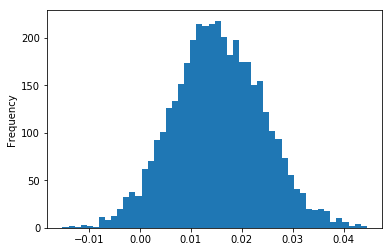

In [40]:
auction_mech_ab = pd.DataFrame(ror_model_robust_trace['alpha_auction_mech'], columns=['EF', 'SB'])
auction_mech_ab['diff'] = auction_mech_ab['EF'] - auction_mech_ab['SB']

prob_EF_gt_SB = len(auction_mech_ab[auction_mech_ab['diff'] > 0]) / len(auction_mech_ab)
mean_diff = auction_mech_ab['diff'].mean()
print('P(EF-effect > SB-effect) = {}'.format(prob_EF_gt_SB))
print('mean difference in RoR between EF and EB auctions = {}'.format(mean_diff))

_ = auction_mech_ab['diff'].plot(kind='hist', bins=50)

It is conclusive that EF auction mechanism outperform SB auction mechanisms, even after controlling for for the number of bidders and variation in local market structure (i.e. trading country).

#### Analysis #2 - Quantifying the Impact of Bidders-Per-Lot
We would like to understand how BPL impacts the RoR for a lot, in isolation of all other variables. We achieve this by sampling form the the posterior predictive distribution while setting all other numerical variables to their average values (which is 0 as we have standardised the input data), and, by considering only the EF auction mechanim as used by the International country.

100%|██████████| 1000/1000 [00:00<00:00, 1960.89it/s]


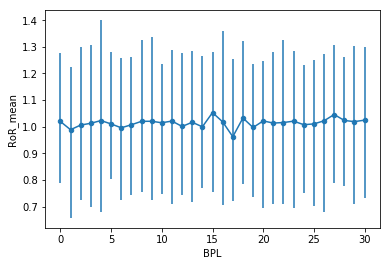

In [41]:
def BPL_control_data(n):
    # setup BPCc support
    BPL_mean = model_data['BPL'].mean()
    BPL_std = model_data['BPL'].std()
    BPL_range = np.linspace(0, n, n+1)
    BPL_range_stdised = (BPL_range - BPL_mean) / BPL_std
    # setup all other numerical variates at average/control levels
    all_other_vars = np.zeros(n+1)
    # setup categorical variabes to be EF auctions for International
    auction_mech_fix = np.zeros(n+1)
    country_fix = np.zeros(n+1) + 16
    # set values on model variables
    lots.set_value(all_other_vars)
    mean_rsv.set_value(all_other_vars)
    avg_start_bid.set_value(all_other_vars)
    BPL.set_value(BPL_range_stdised)
    auction_mech.set_value(auction_mech_fix.astype('int32'))
    country.set_value(country_fix.astype('int32'))
    start_bids.set_value(all_other_vars.astype('int32'))
    return BPL_range

BPL_support = BPL_control_data(30).reshape(-1, 1)
BPL_pp_dist = pm.sample_ppc(ror_model_robust_trace, model=ror_model_robust, samples=1000)['Y_obs']
RoR_pp_mean = BPL_pp_dist.mean(axis=0).reshape(-1, 1)
RoR_pp_lwr = RoR_pp_mean - np.percentile(BPL_pp_dist, 2.5, axis=0).reshape(-1, 1)
RoR_pp_upr = np.percentile(BPL_pp_dist, 97.5, axis=0).reshape(-1, 1) - RoR_pp_mean

BPL_control_df = pd.DataFrame(
    np.hstack([BPL_support, RoR_pp_mean, RoR_pp_lwr, RoR_pp_upr]),
    columns=['BPL', 'RoR_mean', 'RoR_lwr', 'RoR_upr'])

_ = (BPL_control_df
     .plot(kind='scatter', x='BPL', y='RoR_mean')
     .errorbar(x=BPL_control_df['BPL'], y=BPL_control_df['RoR_mean'], 
               yerr=[BPL_control_df['RoR_lwr'], BPL_control_df['RoR_upr']]))

We can see that BPL has a neutral impact on performance - this is somewhat off and needs to be further investigated. Maybe not all bidders are 'serious' and there are a lot of 'noisey' bids that are not contributing the efficiency of the price discovery process.

#### Analysis #3 - Posterior Predictive Check
As a check on the distributional properties of our model, we compare the posterior predictive distribution (below in blue), to the distribution of the test dataset (below orange, overlayed onto the posterior predictive distribution).

100%|██████████| 100/100 [00:00<00:00, 894.90it/s]


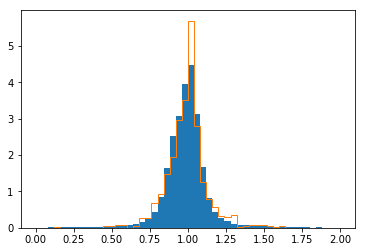

In [42]:
load_train_data()
pp_test_dist = pm.sample_ppc(ror_model_robust_trace, model=ror_model_robust, samples=100)['Y_obs']

_ = plt.hist([pp_test_dist.ravel()], density=True, bins=50, histtype='bar', range=[0, 2])
_ = plt.hist([y_test], density=True, bins=50, histtype='step', range=[0, 2])

By visual inspection alone, it is possible to see that the distributions are a good match, but that the distribution of the data is more leptokurtic than that of the model's - i.e. the 'tails' of the data are fatter than the Student-T we have used for the likelihood.

## Conclusions
- English Forward auctions are likely to out-perform sealed bid auctions, on average;
- the number of lots offered has a small negative impact on price - e.g adding 100 more lots than usual will reduce prices by ~2%, on average;
- increases in the average lot value will have a small negative impact on price - e.g for every EUR 1,000 increase, prices will drop by ~10bps, on average;
- the number of bidders per-lot has an anomalously absent impact on RoR; 
- whenever the average number of 'noise' bidders is raised by 1, prices drop by 2%, on average; and,
- there is a lot of variation in regional market microstructure - e.g the factors that determine supply-and-demand dynamics (how much of what can be sold to whom, given competition), varies considerably on a regional basis.